In [1]:
import sys
sys.path.append('../')
from QC import *
# custom PU two-step method
from PU_twostep import twoStep
# pipeline functions
from qc_pipeline import *
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [2]:
# basic classifier to use
from sklearn.linear_model import RidgeClassifier

In [3]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

Read in normal human colon sample

In [4]:
s1 = sc.read_h5ad('../data/3072-AS-3-ACAGTG_S3.h5ad')
# see how many "good cells" Ken labeled (1)
s1.obs['ken_filter'].value_counts()

0    7576
1    2990
Name: ken_filter, dtype: int64

In [5]:
%%time
# preprocess data with fcc recipe
sc.pp.filter_genes(s1, min_cells=1)
recipe_fcc(s1, X_final='arcsinh_norm', mito_names='^mt-')

CPU times: user 13.7 s, sys: 1.91 s, total: 15.6 s
Wall time: 15.6 s


In [6]:
# switch ken's filter's labels for ease of comparison
s1.obs['ken_filter_reverse'] = 1
s1.obs.loc[(s1.obs['ken_filter'] == 1), 'ken_filter_reverse'] = 0

In [7]:
s1

AnnData object with n_obs × n_vars = 10566 × 29944 
    obs: 'ken_filter', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'arcsinh_n_genes_by_counts', 'arcsinh_total_counts', 'gf_icf_total', 'log1p_norm_factor', 'ken_filter_reverse'
    var: 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'raw_counts', 'arcsinh_norm', 'gf_icf', 'log1p_norm'

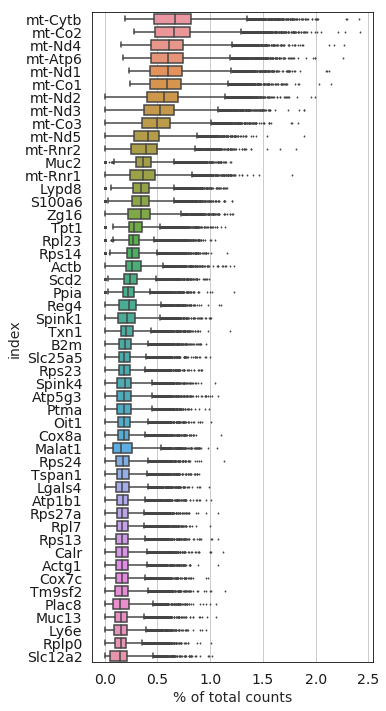

In [8]:
# pct counts in top 50 genes might be useful, as top genes are typically ambient (in empty drops at high frequency)
sc.pl.highest_expr_genes(s1, n_top=50)

## Functions

In [9]:
def autoThresh(adata, obs_cols=[
        "arcsinh_total_counts",
        "arcsinh_n_genes_by_counts",
        "gf_icf_total",
        "pct_counts_mito",
        "pct_counts_in_top_50_genes",
    ],
    method="otsu"):
    thresholds = dict.fromkeys(obs_cols)  # initiate output dictionary
    for col in obs_cols:
        tmp = np.array(adata.obs[col])
        if method == "otsu":
            thresholds[col] = threshold_otsu(tmp)
        elif method == "li":
            thresholds[col] = threshold_li(tmp)
        elif method == "mean":
            thresholds[col] = threshold_mean(tmp)
        elif method == "isodata":
            thresholds[col] = threshold_isodata(tmp)
        elif method == "yen":
            thresholds[col] = threshold_yen(tmp)
        elif method == "triangle":
            thresholds[col] = threshold_triangle(tmp)
        else:
            raise ValueError(
                "Please provide a valid threshold method ('otsu', 'li', 'mean')."
            )

    return thresholds

In [10]:
def pcaPlot(adata, threshMethod, xAxis, yAxis):
    ax = sc.pl.scatter(adata=s1, y=yAxis, x=xAxis, color='ken_filter_reverse', show=False)
    ax.axvline(threshMethod[xAxis], color='r')
    ax.axhline(threshMethod[yAxis], color='r')
    plt.show()

In [11]:
# calculate the set difference between the threshold method and ken's filter, or the difference between the threshold method and another method
def findDifference(adata, filterName1, filterName2, doPrint = 'p'):
    filter1Index = adata.obs.loc[adata.obs[filterName1] == 0].index
    filter2Index = adata.obs.loc[adata.obs[filterName2] == 0].index
    
    filter1DifFilter2 = len(set(filter1Index).difference(set(filter2Index))) # elements present in filter1 but not in filter2
    filter2DifFilter1 = len(set(filter2Index).difference(set(filter1Index))) # elements present in filter2 but not in filter1
    totalDif = len(set(s1.obs_names[s1.obs[filterName1]==0]) ^ set(s1.obs_names[s1.obs[filterName2]==0])) # total difference
    
    if (doPrint.lower() == 'p'):
        print("Elements present in ", filterName1, " but not in ", filterName2, ": ", filter1DifFilter2)
        print("Elements present in ", filterName2, " but not in ", filterName1, ": ", filter2DifFilter1)
        print("Total difference: ", totalDif)
        
    return (filter1DifFilter2, filter2DifFilter1, totalDif)

In [12]:
def parametersTest(adata, threshMethod):
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts'], 
                  directions=['above'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','pct_counts_mito'], 
                  directions=['above','below'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','gf_icf_total'], 
                  directions=['above','above'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','arcsinh_total_counts'], 
                  directions=['above','above'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','pct_counts_in_top_50_genes'], 
                  directions=['above','below'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','gf_icf_total','pct_counts_mito'], 
                  directions=['above','above','below'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','pct_counts_mito','pct_counts_in_top_50_genes'], 
                  directions=['above','below','below'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')
    
    filter_thresh_obs(adata, 
                  threshMethod,
                  obs_cols=['arcsinh_n_genes_by_counts','arcsinh_total_counts','gf_icf_total','pct_counts_mito','pct_counts_in_top_50_genes'], 
                  directions=['above','above','above','below','below'],
                  name='thresh_filter'
                 )
    findDifference(s1, 'thresh_filter', 'ken_filter_reverse')

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [13]:
from skimage.filters import threshold_li, threshold_otsu, threshold_isodata, threshold_mean, threshold_yen, threshold_triangle # popular thresholding methods
from scipy.stats import mode

In [14]:
threshOtsu = autoThresh(s1, method='otsu')
threshLi = autoThresh(s1, method='li')
threshMean = autoThresh(s1, method='mean')
threshIsodata = autoThresh(s1, method='isodata')
threshYen = autoThresh(s1, method='yen')
threshTriangle = autoThresh(s1, method='triangle')

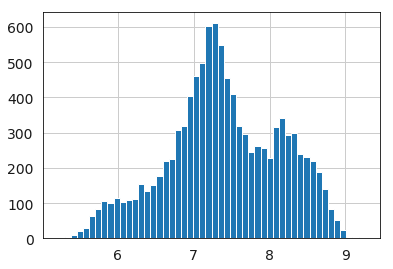

In [15]:
_ = plt.hist(s1.obs['arcsinh_n_genes_by_counts'], bins=50)

In [16]:
def peakMax():
    # get subset of array from 0 to where the threshold ends
    firstArray = _[0]
    secondArray = _[1]
    secondArrayEnd = np.where(secondArray <= threshMean['arcsinh_n_genes_by_counts'])
    subFirstArray = firstArray[slice(0, np.amax(secondArrayEnd))]
    subSecondArray = secondArray[slice(0, np.amax(secondArrayEnd))]
    
    # find the peak of a distribution within the range of 0 and the threshold
    maxValue = max(subFirstArray)
    maxIndex = np.where(subFirstArray == np.amax(subFirstArray))
    peakMax = subSecondArray[maxIndex]
    
    return peakMax[0]

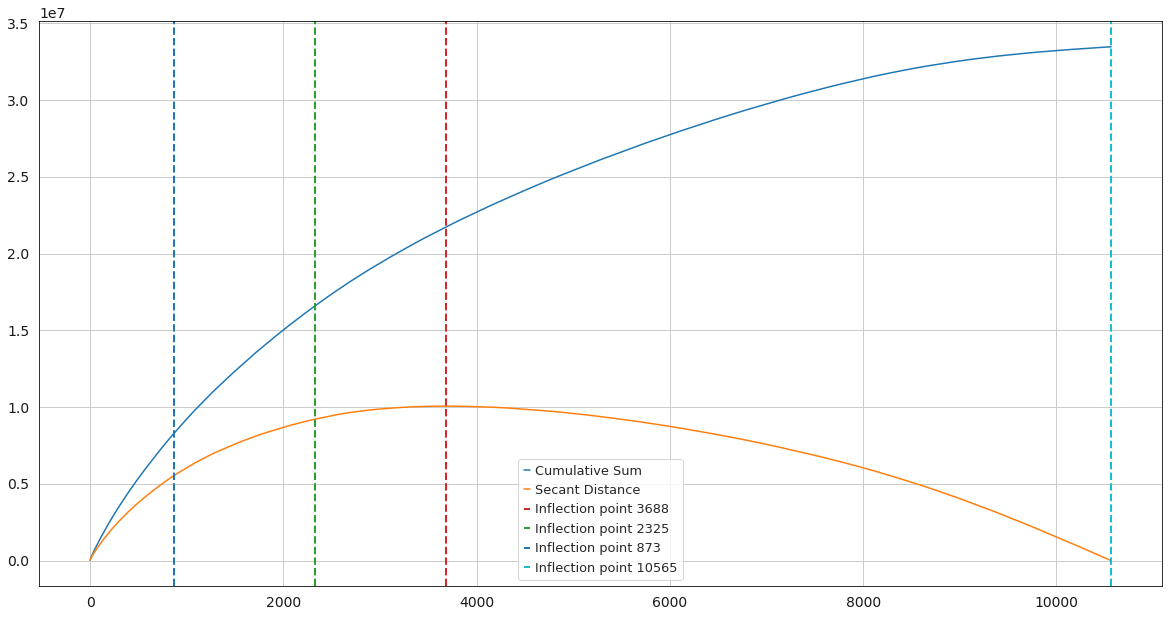

{0: 3688, 30: 2325, 70: 873, 100: 10565}

In [17]:
# inflection_percentiles are percentages of maximum secant distance. we wanna pick one to the right of the maximum
find_inflection(s1, inflection_percentiles = [0,30,70,100], output_prefix='')

In [18]:
s1.obs['total_counts'][3900] # see the total counts for the cutoff point

2875.0

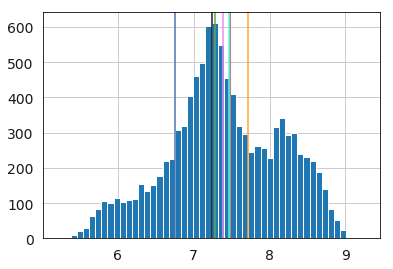

In [19]:
_ = plt.hist(s1.obs['arcsinh_n_genes_by_counts'], bins=50)
plt.axvline(threshOtsu['arcsinh_n_genes_by_counts'], color='r') # otsu
plt.axvline(threshLi['arcsinh_n_genes_by_counts'], color='g') # li
plt.axvline(threshIsodata['arcsinh_n_genes_by_counts'], color='#52FFEA') # cyan
plt.axvline(threshMean['arcsinh_n_genes_by_counts'], color='#EE8DF1') # pink
plt.axvline(threshYen['arcsinh_n_genes_by_counts'], color='b') # blue
plt.axvline(threshTriangle['arcsinh_n_genes_by_counts'], color='#FEA437') # orange
plt.axvline(peakMax(), color='k') # black
#plt.axvline(minCellCounts, color='c') # cyan
#plt.axvline(dtMeanLi, color = 'g') # green
#plt.axvline(dtMeanMean, color = 'm') # magenta
#plt.axvline(thresholdSelection(), color = 'g')
#plt.axvline(s1.obs['arcsinh_total_counts'][13219], color='y') # threshold chosen from one of the inflection point percentage cutoffs

In [20]:
# red = otsu
# green = li
# bright pink = mean
# cyan = isodata
# blue = yen
# orange = triangle
# black = peakMax
# yellow = inflection point (70)

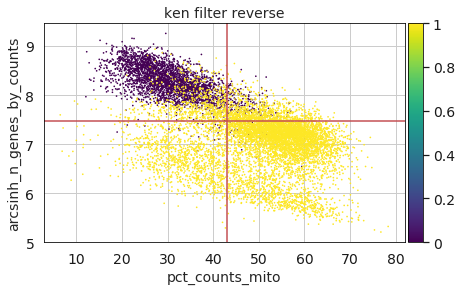

In [21]:
pcaPlot(s1, threshOtsu, 'pct_counts_mito', 'arcsinh_n_genes_by_counts')

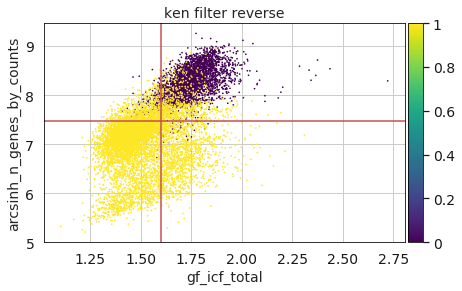

In [22]:
pcaPlot(s1, threshOtsu, 'gf_icf_total', 'arcsinh_n_genes_by_counts')

In [27]:
parametersTest(s1, threshOtsu)

Elements present in  thresh_filter  but not in  ken_filter_reverse :  147
Elements present in  ken_filter_reverse  but not in  thresh_filter :  876
Total difference:  1023
Elements present in  thresh_filter  but not in  ken_filter_reverse :  147
Elements present in  ken_filter_reverse  but not in  thresh_filter :  876
Total difference:  1023
Elements present in  thresh_filter  but not in  ken_filter_reverse :  117
Elements present in  ken_filter_reverse  but not in  thresh_filter :  1141
Total difference:  1258
Elements present in  thresh_filter  but not in  ken_filter_reverse :  145
Elements present in  ken_filter_reverse  but not in  thresh_filter :  878
Total difference:  1023
Elements present in  thresh_filter  but not in  ken_filter_reverse :  147
Elements present in  ken_filter_reverse  but not in  thresh_filter :  876
Total difference:  1023
Elements present in  thresh_filter  but not in  ken_filter_reverse :  117
Elements present in  ken_filter_reverse  but not in  thresh_filte

In [28]:
parametersTest(s1, threshLi)

Elements present in  thresh_filter  but not in  ken_filter_reverse :  187
Elements present in  ken_filter_reverse  but not in  thresh_filter :  833
Total difference:  1020
Elements present in  thresh_filter  but not in  ken_filter_reverse :  187
Elements present in  ken_filter_reverse  but not in  thresh_filter :  833
Total difference:  1020
Elements present in  thresh_filter  but not in  ken_filter_reverse :  151
Elements present in  ken_filter_reverse  but not in  thresh_filter :  894
Total difference:  1045
Elements present in  thresh_filter  but not in  ken_filter_reverse :  186
Elements present in  ken_filter_reverse  but not in  thresh_filter :  834
Total difference:  1020
Elements present in  thresh_filter  but not in  ken_filter_reverse :  186
Elements present in  ken_filter_reverse  but not in  thresh_filter :  834
Total difference:  1020
Elements present in  thresh_filter  but not in  ken_filter_reverse :  151
Elements present in  ken_filter_reverse  but not in  thresh_filter

In [29]:
parametersTest(s1, threshMean)

Elements present in  thresh_filter  but not in  ken_filter_reverse :  81
Elements present in  ken_filter_reverse  but not in  thresh_filter :  986
Total difference:  1067
Elements present in  thresh_filter  but not in  ken_filter_reverse :  65
Elements present in  ken_filter_reverse  but not in  thresh_filter :  993
Total difference:  1058
Elements present in  thresh_filter  but not in  ken_filter_reverse :  63
Elements present in  ken_filter_reverse  but not in  thresh_filter :  1846
Total difference:  1909
Elements present in  thresh_filter  but not in  ken_filter_reverse :  78
Elements present in  ken_filter_reverse  but not in  thresh_filter :  1002
Total difference:  1080
Elements present in  thresh_filter  but not in  ken_filter_reverse :  81
Elements present in  ken_filter_reverse  but not in  thresh_filter :  989
Total difference:  1070
Elements present in  thresh_filter  but not in  ken_filter_reverse :  47
Elements present in  ken_filter_reverse  but not in  thresh_filter :  